In [1]:
import tensorflow as tf


In [58]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout, Conv2D, MaxPool2D, Flatten, MaxPooling2D
from keras.optimizers import SGD, Adam ,RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras import  backend as K
from keras.utils import to_categorical, plot_model
from sklearn.metrics import  accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score,classification_report

In [3]:
import mnist_loader
import numpy as np

import matplotlib.pyplot as plt
import torch
import time
from statistics import mean 

#### Note - Work Flow of the expriment is as follows
To check each hyperparameter a model has been created and put it into a array.  <br>
Then models has been trained with training dataset and evaluation data is used to evaluate <br>
Using the history data plots are created and models have been compared in terms of various matrics. <br>
And the experiments have been continued with chosen parameters from previous experiments. <br>
At the end,  performances or both the model with just two fully connected layers and model with the hyper-parameters chosen from experiments is compared against each other. 

In [4]:



training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
training_data = list(training_data)
test_data = list(test_data)
validation_data = list(validation_data)

print(len(training_data),len(validation_data),len(test_data))
trainloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)

def title_calc(label):
    for i in range(len(label)):
        if(label[i][0] == 1):
            break
    return i




def reformat_train(tup):
    data,label =tup
    data = data.reshape(1,1,28,28)
    label  = title_calc(label)
    return (data, label)

def reformat(tup):
    data,label =tup
    data = data.reshape(1,1,28,28)
    return (data, label)

train_data =   list(map(reformat_train, training_data))
tst_data =   list(map(reformat, test_data))
val_data =   list(map(reformat, validation_data))

def data_to_tensors(inp_data):
    data    = inp_data[0]
    targets = inp_data[1]
    return [torch.cat(list(map(torch.from_numpy, data))),   torch.tensor(targets)]


train_data = data_to_tensors([*zip(*train_data)])
tst_data = data_to_tensors([*zip(*tst_data)])
val_data = data_to_tensors([*zip(*val_data)])





val_data[0].shape

Arived 1
50000 10000 10000


torch.Size([10000, 1, 28, 28])

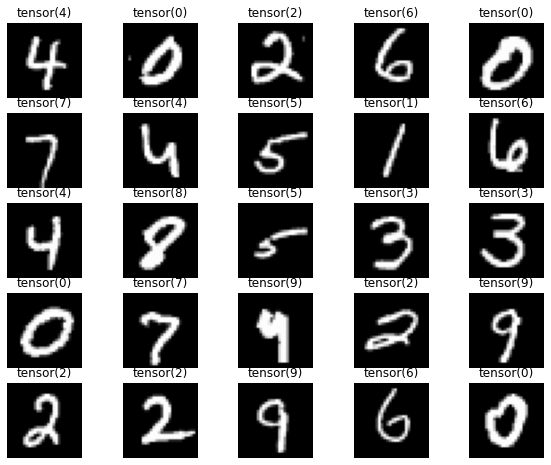

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data[0]), size=(1,)).item()
    img =  train_data[0][sample_idx]
    label = train_data[1][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
   ## img = img.reshape(28,28)
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [6]:
# convert to one-hot vector
x_train = train_data[0]
y_train = train_data[1]
x_val = val_data[0]
y_val = val_data[1]
x_test = tst_data[0]
y_test = tst_data[1]
y_test.shape

torch.Size([10000])

In [7]:
x_train = torch.detach(x_train).numpy()
x_test = torch.detach(x_test).numpy()
x_val = torch.detach(x_val).numpy()
y_train = torch.detach(y_train).numpy()
y_test = torch.detach(y_test).numpy()
y_val = torch.detach(y_val).numpy()


In [8]:


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [9]:
input_size = 28 * 28
x_train = np.reshape(x_train, [50000,28,28,1])
x_test = np.reshape(x_test, [10000,28,28,1])
x_val = np.reshape(x_val, [10000,28,28,1])
x_train.shape

(50000, 28, 28, 1)

In [10]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

In [11]:
#Function used to generate plots
def plot_generator(title, history, names, count, accuracy_bound = 0.98):
    plt.figure(figsize=(20,5))
    for i in range(count):
        plt.plot(history[i].history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    axes = plt.gca()
    axes.set_ylim([accuracy_bound,1])
    plt.savefig(title + '-model_accuracy.png', bbox_inches='tight')
    plt.show()
    accuracies = [max(history[j].history['accuracy']) for j in range(count)]
    val_acc = [mean(history[j].history['val_accuracy']) for j in range(count)]
    train_time = [history[j].history['training_time'] for j in range(count)]
    inference_time = [history[j].history['inference_time'] for j in range(count)]
    loss = [max(history[j].history['loss']) for j in range(count)]
    val_loss = [max(history[j].history['val_loss']) for j in range(count)]
    f = plt.figure(figsize=(20,10))
    ax1 = f.add_subplot(241)
    ax4 = f.add_subplot(242)
    ax2 = f.add_subplot(243)
    ax3 = f.add_subplot(244)
    ax5 = f.add_subplot(245)
    ax6 = f.add_subplot(246)
    ax1.plot(names,accuracies)
    ax1.set_title('train accuracy')
    ax1.set(xlabel='model', ylabel='accuracy')
    ax4.plot(names,val_acc)
    ax4.set_title('val accuracy')
    ax4.set(xlabel='model', ylabel='accuracy')
    ax2.plot(names,train_time)
    ax2.set_title('model train_time')
    ax2.set(xlabel='model', ylabel='time')
    ax3.plot(names,inference_time)
    ax3.set_title('model inference_time')
    ax3.set(xlabel='model', ylabel='time')
    ax5.plot(names,loss)
    ax5.set_title('model train_loss')
    ax5.set(xlabel='model', ylabel='loss')
    ax6.plot(names,val_loss)
    ax6.set_title('model val_loss')
    ax6.set(xlabel='model', ylabel='loss')
    #plt.savefig(title + '-rest_data.png', bbox_inches='tight')
    plt.show()
    return

## Comparing CNN layer with Fully connected layer

First experiment is done to check which type of layer is better for the neural network. We did a comparison between a Fully connection layer vs a Convolutional layer
Note- Convolution layer perform well for image processing as it is able to extract patch wise data effectively as only a neighborhood of data is used for the output for the layer

In [12]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
count = 2
neural_network = [0] *2

for j in range(count):
    neural_network[j] = Sequential()
    neural_network[j].add(keras.Input(shape=(28,28,1)))
    if j==0:
        neural_network[j].add(Conv2D(24,kernel_size=(5,5),padding='same',activation='relu'))
        neural_network[j].add(MaxPool2D(pool_size=(2, 2)))
        neural_network[j].add(Flatten())
    if j ==1:
        neural_network[j].add(Flatten())
        neural_network[j].add(Dense(256, activation='relu'))
    neural_network[j].add(Dense(10, activation='softmax'))
    neural_network[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
history = [0] * count
names = ["CNN","Fully Connected"]
epochs = 20
for j in range(count):
    start = time.time()
    #Both trainning and evaluation is done
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print("Comparison {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_fully_vs_cnn = history


313/313 [==============================] - 1s 2ms/step
Comparison CNN: Epochs=20, Train accuracy=0.99788, Validation accuracy=0.98740,trainning_time=77.75451, ,inference_time=0.69413
313/313 [==============================] - 0s 845us/step
Comparison Fully Connected: Epochs=20, Train accuracy=0.99926, Validation accuracy=0.98120,trainning_time=22.73275, ,inference_time=0.40219


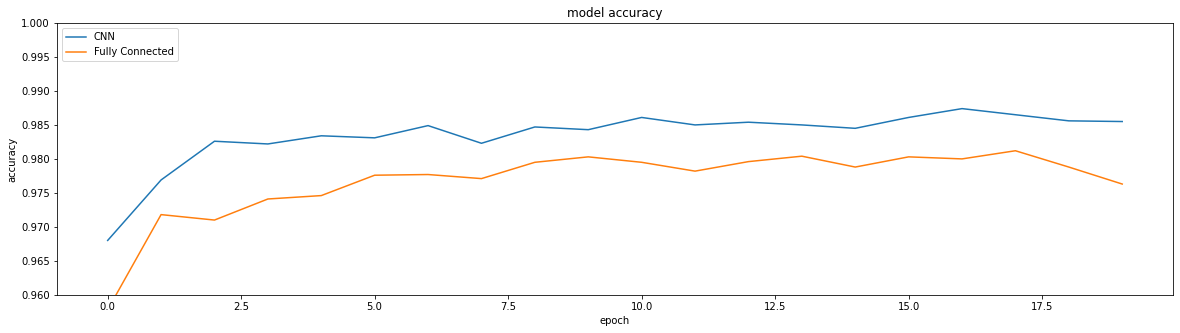

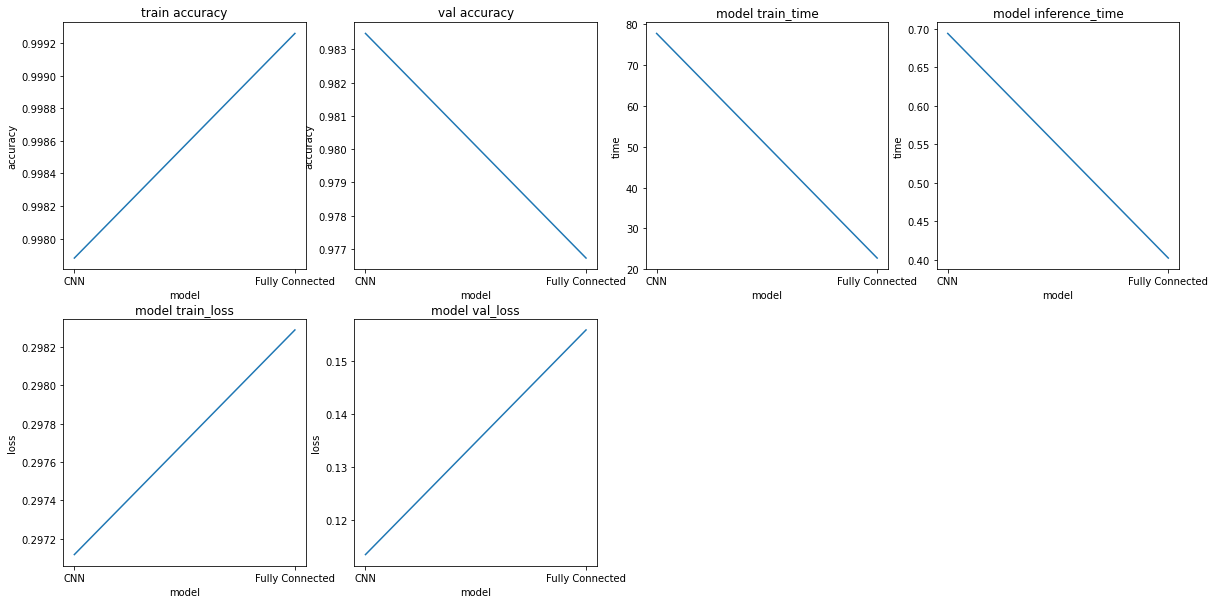

In [14]:
plot_generator("fully_vs_cnn",history_fully_vs_cnn, names, count, 0.96)

Convolution layer holds higher validation accuracy than the Fully connected, moreover the train and validation accuracies proves that Fully connected layer is overfitted.So it is prefered that having a Convolution layer is better than fully connected layer for image processing perpose.

Decision - Use a convolutional layer.

-----

## Experimenting with Different Convolutional layers

This experiment is done to decide the optimum number of Convolutional layers in the neural network
Increasing the number of layers, reduce the bias and increase the variance which enlarge the possibility of overfitting.

In [15]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
count = 4
neural_network = [0] *count

for j in range(count):
    neural_network[j] = Sequential()
    neural_network[j].add(keras.Input(shape=(28,28,1)))
    if j>0:
        neural_network[j].add(Conv2D(24,kernel_size=(5,5),padding='same',activation='relu'))
        neural_network[j].add(MaxPool2D(pool_size=(2, 2)))
    if j>1:
        neural_network[j].add(Conv2D(48,kernel_size=(5,5),padding='same',activation='relu'))
        neural_network[j].add(MaxPool2D())
    if j>2:
        neural_network[j].add(Conv2D(64,kernel_size=(5,5),padding='same',activation='relu'))
        neural_network[j].add(MaxPool2D(padding='same'))
    neural_network[j].add(Flatten())
    neural_network[j].add(Dense(256, activation='relu'))
    neural_network[j].add(Dense(10, activation='softmax'))
    neural_network[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = [0] * count
names = ["(C-layers)x0","(C-layers)x1","(C-layers)x2","(C-layers)x3"]
epochs = 20
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print(" {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_cnn_kayers = history

313/313 [==============================] - 0s 844us/step
 (C-layers)x0: Epochs=20, Train accuracy=0.99972, Validation accuracy=0.98140,trainning_time=22.95674, ,inference_time=0.40237
313/313 [==============================] - 1s 2ms/step
 (C-layers)x1: Epochs=20, Train accuracy=0.99984, Validation accuracy=0.98980,trainning_time=104.94455, ,inference_time=0.69866
313/313 [==============================] - 1s 2ms/step
 (C-layers)x2: Epochs=20, Train accuracy=0.99920, Validation accuracy=0.99250,trainning_time=210.95939, ,inference_time=0.86804
313/313 [==============================] - 1s 3ms/step
 (C-layers)x3: Epochs=20, Train accuracy=0.99888, Validation accuracy=0.99230,trainning_time=257.00830, ,inference_time=1.01950


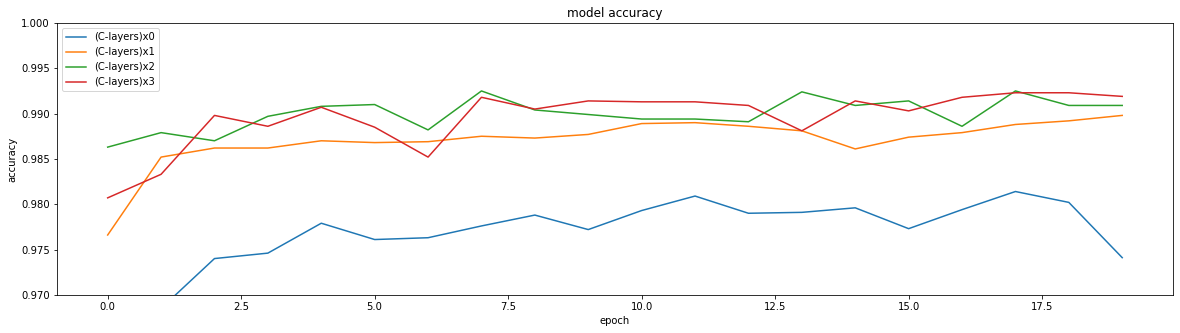

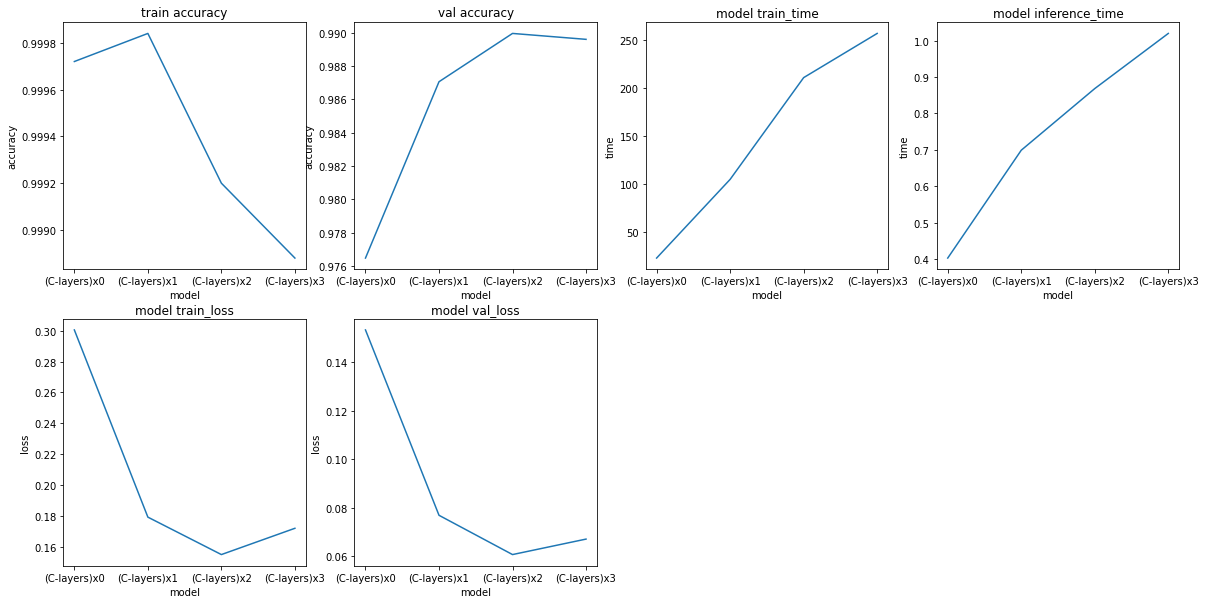

In [17]:

plot_generator("cnn_kayers",history_cnn_kayers, ["(C-layers)x0","(C-layers)x1","(C-layers)x2","(C-layers)x3"], 4, 0.97)

Though model with 3 layers has the highest validation accuracy the trainning and inference time is the highest as well due to model complexity. We decided to continue with two hidden convolution layers which significantly increase the validation accuracy.

Decision - Use two hidden Covolutional Layers

## Experimenting with Different Map sizes

This experiment is done to decide the optimum number of map size of convolutional layers in the neural network
Increasing the number of map size, reduce the bias and increase the variance which enlarge the possibility of overfitting.

In [18]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
count = 6
neural_network = [0] *count
for j in range(6):
    neural_network[j] = Sequential()
    neural_network[j].add(Conv2D(j*8+8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Conv2D(j*16+16,kernel_size=5,activation='relu'))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Flatten())
    neural_network[j].add(Dense(256, activation='relu'))
    neural_network[j].add(Dense(10, activation='softmax'))
    neural_network[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
history = [0] * count
names = ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"]
epochs = 20
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print("{0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_map_size = history

313/313 [==============================] - 1s 2ms/step
8 maps: Epochs=20, Train accuracy=0.99922, Validation accuracy=0.99060,trainning_time=67.72826, ,inference_time=0.67336
313/313 [==============================] - 1s 2ms/step
16 maps: Epochs=20, Train accuracy=0.99890, Validation accuracy=0.99150,trainning_time=85.82878, ,inference_time=0.67897
313/313 [==============================] - 1s 2ms/step
24 maps: Epochs=20, Train accuracy=0.99896, Validation accuracy=0.99210,trainning_time=107.10427, ,inference_time=0.70144
313/313 [==============================] - 1s 2ms/step
32 maps: Epochs=20, Train accuracy=0.99926, Validation accuracy=0.99320,trainning_time=131.59495, ,inference_time=0.75642
313/313 [==============================] - 1s 2ms/step
48 maps: Epochs=20, Train accuracy=0.99932, Validation accuracy=0.99250,trainning_time=152.25292, ,inference_time=0.80719
313/313 [==============================] - 1s 2ms/step
64 maps: Epochs=20, Train accuracy=0.99948, Validation accuracy

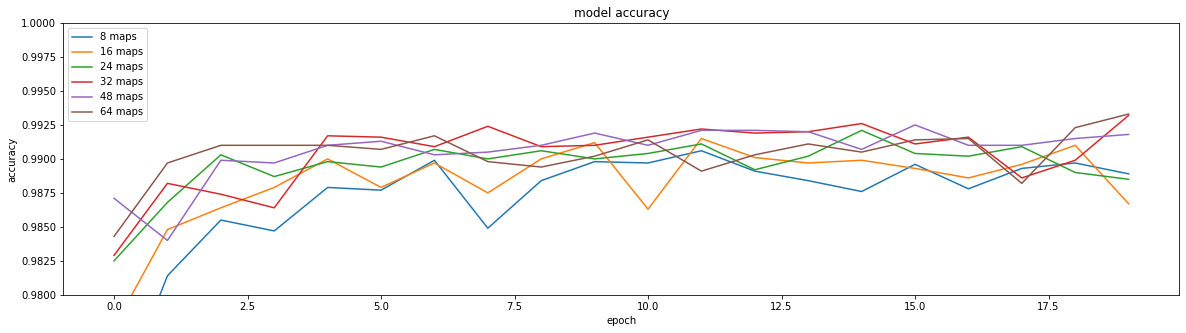

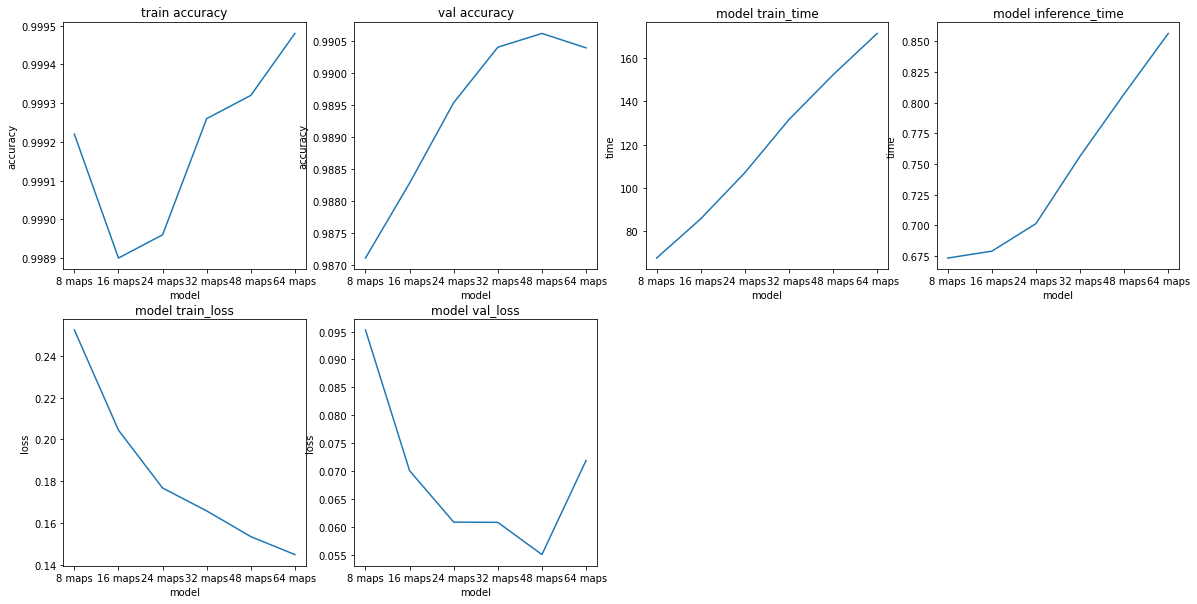

In [20]:

plot_generator("map_size" ,history_map_size, ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"], 6)

Considering the results we can finalize that best map size is 32 for convolutional layer.

Decision - Use 32 as the map size for the convolutional layers

## Experimenting with Different Dense layer sizes

This experiment is done to decide whether to add a dense layer prior to softmax layer, if that so what should be the output dimension of it.
Increasing the number of dimensions, reduce the bias and increase the variance which enlarge the possibility of overfitting.

In [21]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
count = 8
neural_network = [0] *count

for j in range(8):
    neural_network[j] = Sequential()
    neural_network[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Flatten())
    if j>0:
        neural_network[j].add(Dense(2**(j+4), activation='relu'))
    neural_network[j].add(Dense(10, activation='softmax'))
    neural_network[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
history = [0] * count
names = ["0D","32D","64D","128D","256D","512D","1024D","2048D"]
epochs = 20
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print("Dense {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_dense_layer = history

313/313 [==============================] - 1s 2ms/step
Dense 0D: Epochs=20, Train accuracy=0.99928, Validation accuracy=0.99160,trainning_time=123.40389, ,inference_time=0.71804
313/313 [==============================] - 1s 2ms/step
Dense 32D: Epochs=20, Train accuracy=0.99868, Validation accuracy=0.99130,trainning_time=126.11833, ,inference_time=0.74086
313/313 [==============================] - 1s 2ms/step
Dense 64D: Epochs=20, Train accuracy=0.99904, Validation accuracy=0.99210,trainning_time=126.54785, ,inference_time=0.73499
313/313 [==============================] - 1s 2ms/step
Dense 128D: Epochs=20, Train accuracy=0.99934, Validation accuracy=0.99250,trainning_time=128.83406, ,inference_time=0.75524
313/313 [==============================] - 1s 2ms/step
Dense 256D: Epochs=20, Train accuracy=0.99940, Validation accuracy=0.99300,trainning_time=131.57544, ,inference_time=0.76392
313/313 [==============================] - 1s 2ms/step
Dense 512D: Epochs=20, Train accuracy=0.99970, Va

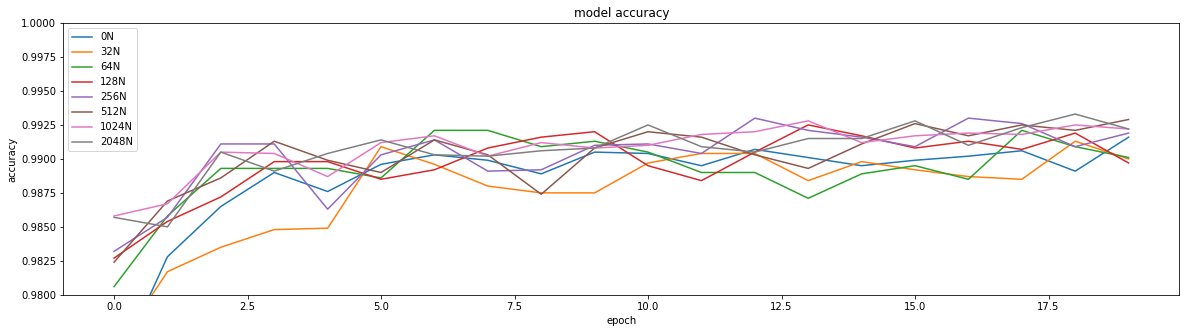

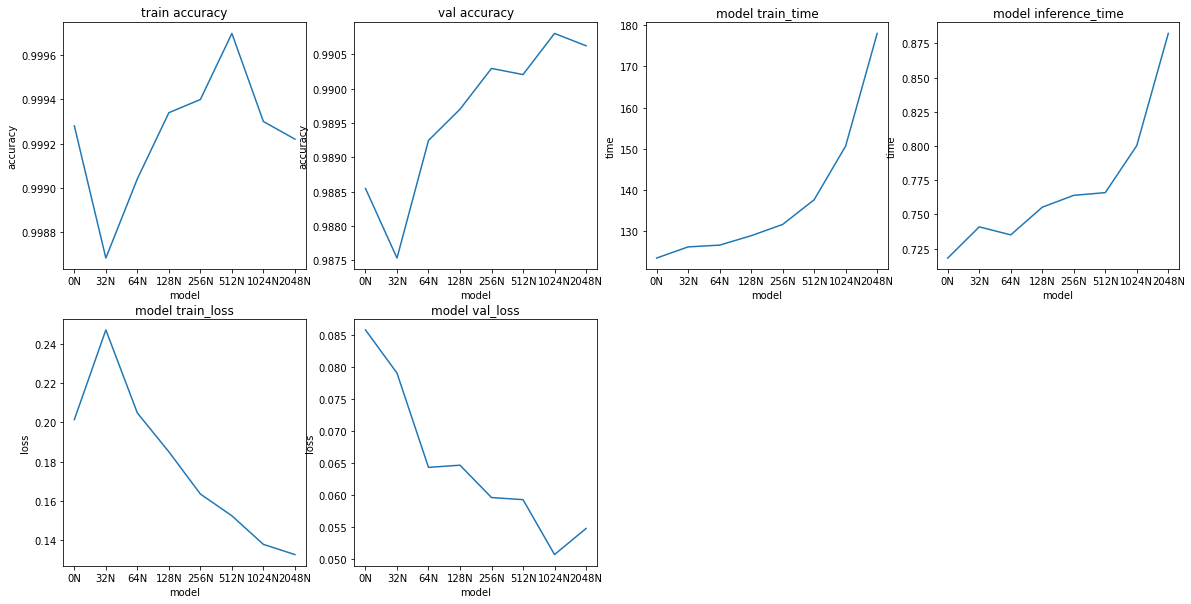

In [23]:
plot_generator("Dense_layer" ,history_dense_layer, ["0N","32N","64N","128N","256N","512N","1024N","2048N"], 8)

Ran the above test several times but we got best accuracy from 128 and 256 from different occations. Therefore considering the complexity factor as well  decided to go with 128.

Decision - Use 256 as the dimension of the dense layer

In [24]:
dense_layer_D = 256

## Experimenting with Different kernel sizes

This experiment is done to decide the kernel size of the convolutional layer.
This value is a hyperparameter of the CNN

In [25]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
count = 7
neural_network = [0] *count
for j in range(count):
    neural_network[j] = Sequential()
    neural_network[j].add(Conv2D(32,kernel_size= 2+j,activation='relu',input_shape=(28,28,1)))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Conv2D(64,kernel_size=2+j,activation='relu'))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Flatten())
    neural_network[j].add(Dense(dense_layer_D, activation='relu'))
    neural_network[j].add(Dense(10, activation='softmax'))
    neural_network[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
history = [0] * count
epochs = 20
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print("Kernel size: {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        2+j,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_kernel_size = history

313/313 [==============================] - 1s 2ms/step
Kernel size: 2: Epochs=20, Train accuracy=0.99958, Validation accuracy=0.99060,trainning_time=104.56454, ,inference_time=0.65713
313/313 [==============================] - 1s 2ms/step
Kernel size: 3: Epochs=20, Train accuracy=0.99946, Validation accuracy=0.99160,trainning_time=118.27734, ,inference_time=0.68317
313/313 [==============================] - 1s 2ms/step
Kernel size: 4: Epochs=20, Train accuracy=0.99936, Validation accuracy=0.99230,trainning_time=118.96861, ,inference_time=0.71884
313/313 [==============================] - 1s 2ms/step
Kernel size: 5: Epochs=20, Train accuracy=0.99916, Validation accuracy=0.99200,trainning_time=128.88275, ,inference_time=0.74681
313/313 [==============================] - 1s 2ms/step
Kernel size: 6: Epochs=20, Train accuracy=0.99964, Validation accuracy=0.99240,trainning_time=122.04723, ,inference_time=0.74502
313/313 [==============================] - 1s 2ms/step
Kernel size: 7: Epochs=20

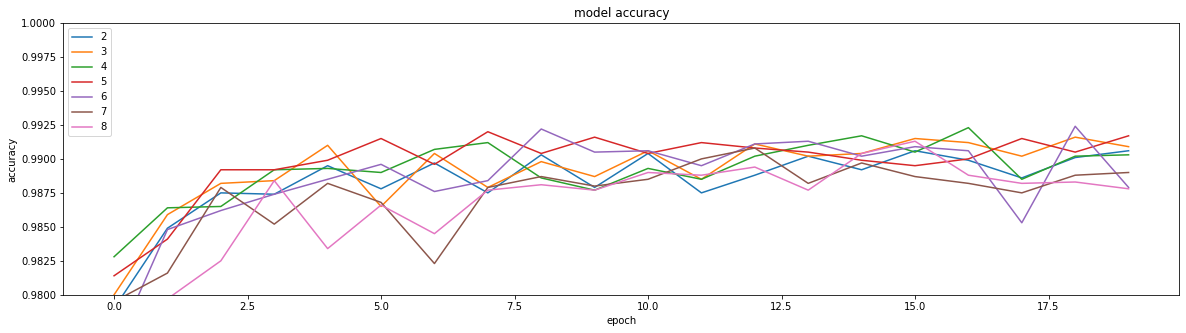

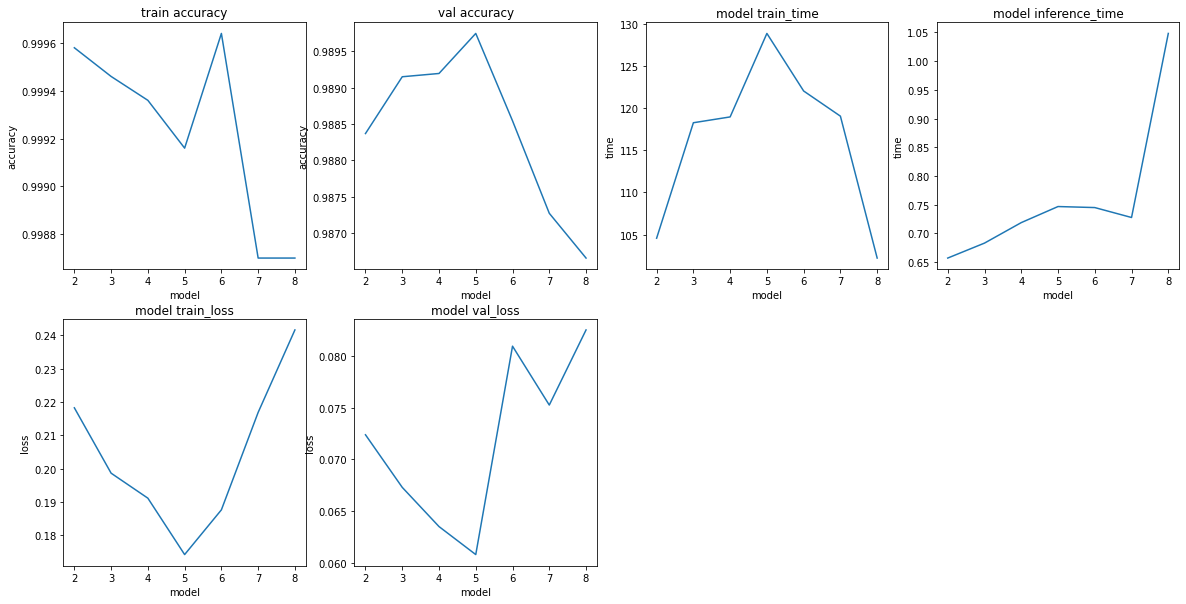

In [27]:
plot_generator("Kernel_size" ,history_kernel_size, [2,3,4,5,6,7,8], 7)

Considering the results we can see that kernel with size 5 has the highest accuracy.


Decision - Use kernel size 5

## Experimenting with Different dropout probabilities

Dropout is done to reduce the complexity of the neural network and avoid overfitting. When the drop out probability is increased the bias of the model increases and the variance decreases.


In [28]:
count = 8
neural_network = [0] *count

for j in range(8):
    neural_network[j] = Sequential()
    neural_network[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(j*0.1))
    neural_network[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(j*0.1))
    neural_network[j].add(Flatten())
    neural_network[j].add(Dense(dense_layer_D, activation='relu'))
    neural_network[j].add(Dropout(j*0.1))
    neural_network[j].add(Dense(10, activation='softmax'))
    neural_network[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
history = [0] * count
names = ["Drop=0","Drop=0.1","Drop=0.2","Drop=0.3","Drop=0.4","Drop=0.5","Drop=0.6","Drop=0.7"]
epochs = 20
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print(" {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_drop_out = history

313/313 [==============================] - 1s 2ms/step
 Drop=0: Epochs=20, Train accuracy=0.99938, Validation accuracy=0.99160,trainning_time=129.46403, ,inference_time=0.74681
313/313 [==============================] - 1s 2ms/step
 Drop=0.1: Epochs=20, Train accuracy=0.99812, Validation accuracy=0.99350,trainning_time=147.49975, ,inference_time=0.75255
313/313 [==============================] - 1s 2ms/step
 Drop=0.2: Epochs=20, Train accuracy=0.99666, Validation accuracy=0.99350,trainning_time=146.51578, ,inference_time=0.75138
313/313 [==============================] - 1s 2ms/step
 Drop=0.3: Epochs=20, Train accuracy=0.99434, Validation accuracy=0.99430,trainning_time=146.52342, ,inference_time=0.75216
313/313 [==============================] - 1s 2ms/step
 Drop=0.4: Epochs=20, Train accuracy=0.99074, Validation accuracy=0.99380,trainning_time=144.79370, ,inference_time=0.75106
313/313 [==============================] - 1s 2ms/step
 Drop=0.5: Epochs=20, Train accuracy=0.98582, Valida

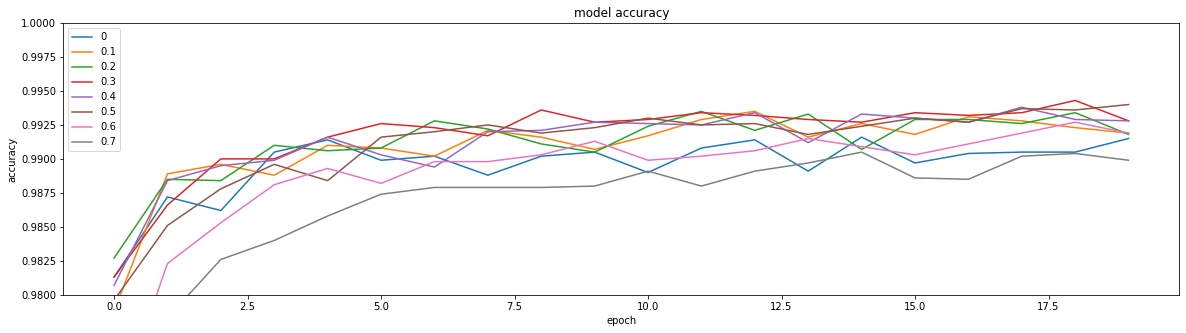

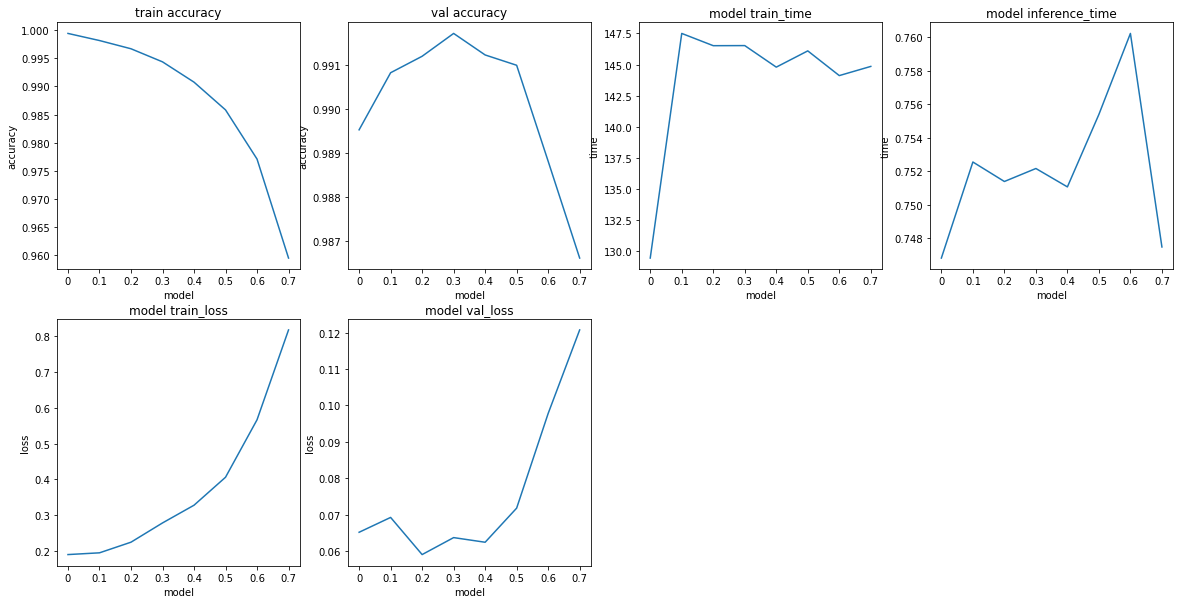

In [30]:
plot_generator("Drop_out" ,history_drop_out, ["0","0.1","0.2","0.3","0.4","0.5","0.6","0.7"], count)

Considering the results we can see the dropout probability 0.3 gives the best performance.


Decision - Dropout probability 0.3

## Experimenting with Different weight initializers

Weight initializers have a impact on the final accuracy and the convergence time. We analys each initializer and decided the best one.

In [31]:

weight_inifializations = ['zeros', 'ones', 'Orthogonal', 'RandomNormal','RandomUniform','glorot_normal','glorot_uniform', 'he_normal','he_uniform','lecun_uniform']
neural_network = {}
count = len(weight_inifializations)
for j in range(count):
    neural_network[j] = Sequential()
    neural_network[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1), kernel_initializer= weight_inifializations[j], bias_initializer='zeros'))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Conv2D(64,kernel_size=5,activation='relu', kernel_initializer= weight_inifializations[j], bias_initializer='zeros'))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Flatten())
    neural_network[j].add(Dense(dense_layer_D, activation='relu', kernel_initializer=weight_inifializations[j], bias_initializer='zeros'))
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Dense(10, activation='softmax', kernel_initializer=weight_inifializations[j], bias_initializer='zeros'))
    neural_network[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:

history = {}
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print(" {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        weight_inifializations[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_weight_init = history

313/313 [==============================] - 1s 2ms/step
 zeros: Epochs=20, Train accuracy=0.11356, Validation accuracy=0.10640,trainning_time=144.51863, ,inference_time=0.75237
313/313 [==============================] - 1s 2ms/step
 ones: Epochs=20, Train accuracy=0.14186, Validation accuracy=0.14650,trainning_time=143.37178, ,inference_time=0.74778
313/313 [==============================] - 1s 2ms/step
 Orthogonal: Epochs=20, Train accuracy=0.99434, Validation accuracy=0.99390,trainning_time=145.35197, ,inference_time=0.75577
313/313 [==============================] - 1s 2ms/step
 RandomNormal: Epochs=20, Train accuracy=0.99408, Validation accuracy=0.99410,trainning_time=144.46190, ,inference_time=0.76271
313/313 [==============================] - 1s 2ms/step
 RandomUniform: Epochs=20, Train accuracy=0.99384, Validation accuracy=0.99380,trainning_time=143.46055, ,inference_time=0.76771
313/313 [==============================] - 1s 2ms/step
 glorot_normal: Epochs=20, Train accuracy=0.99

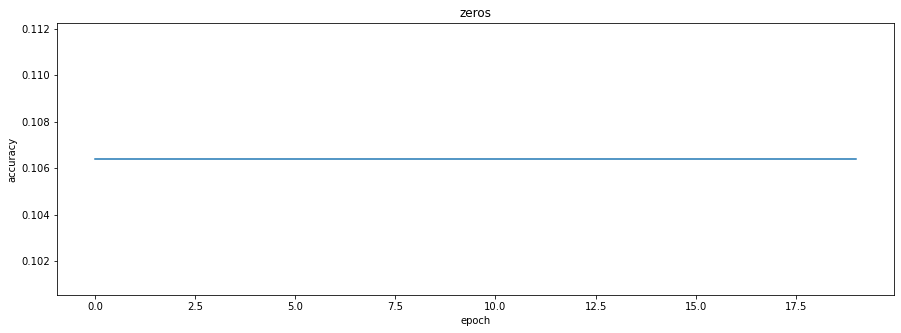

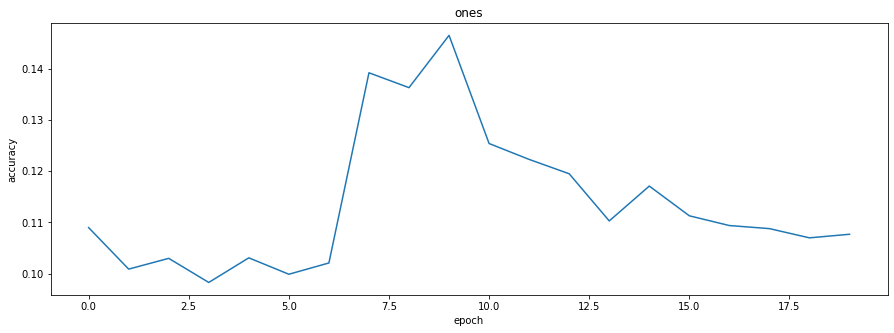

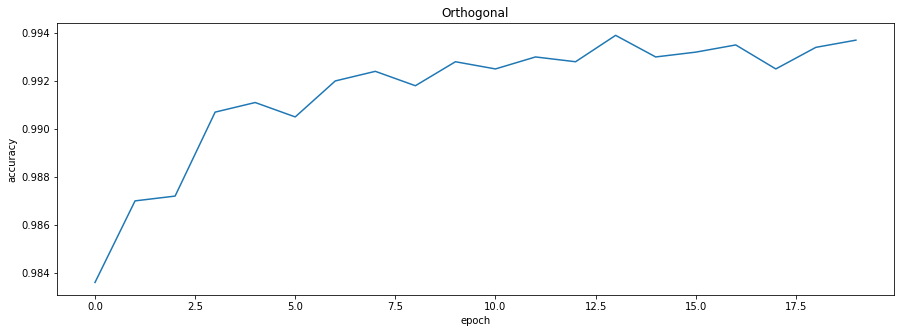

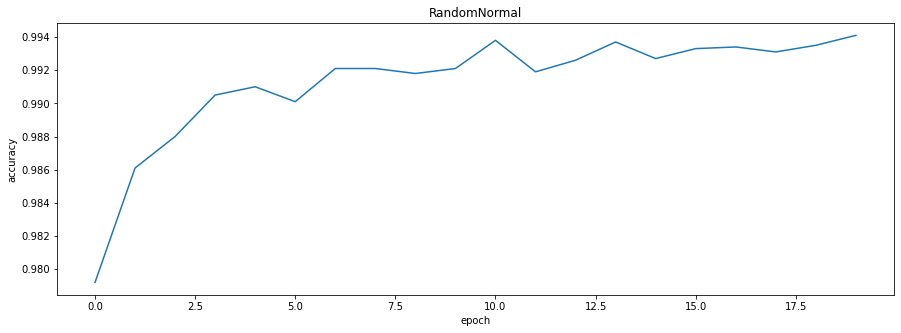

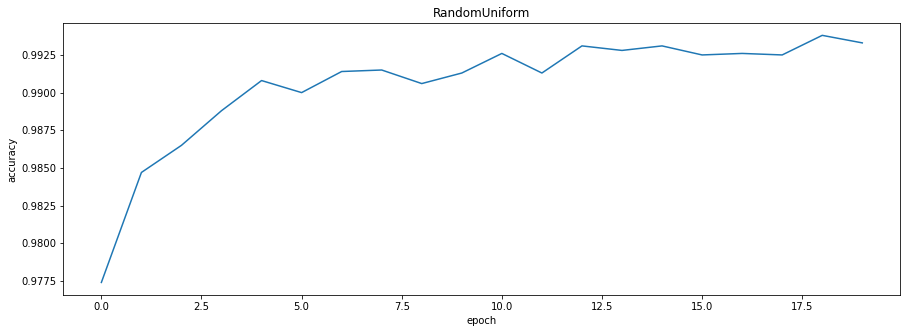

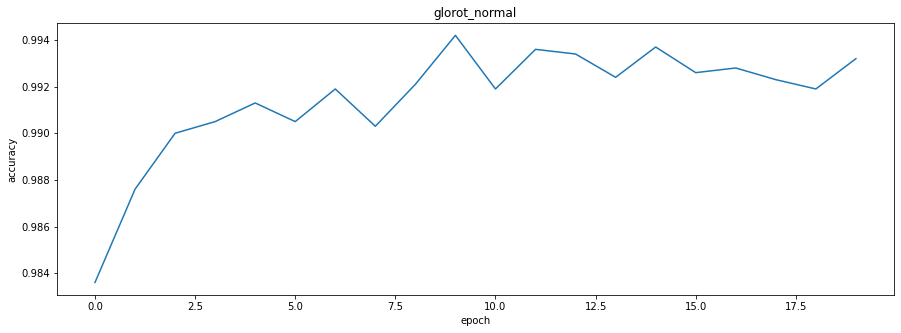

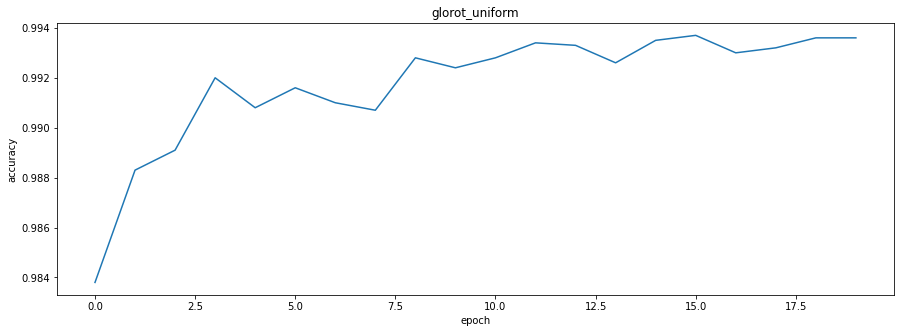

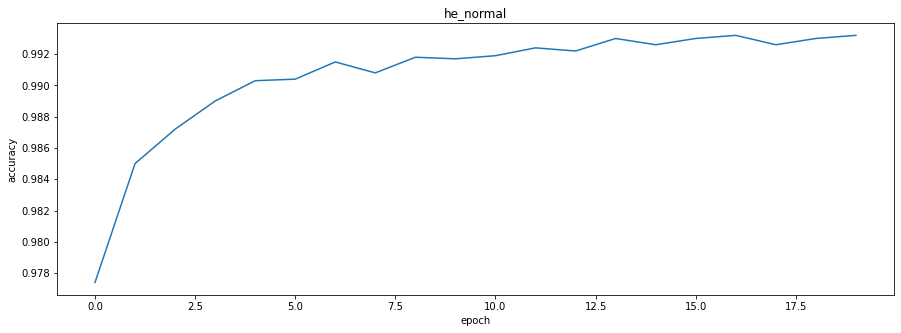

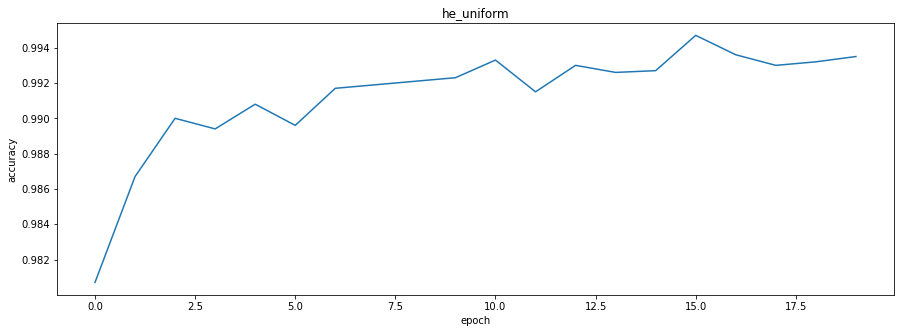

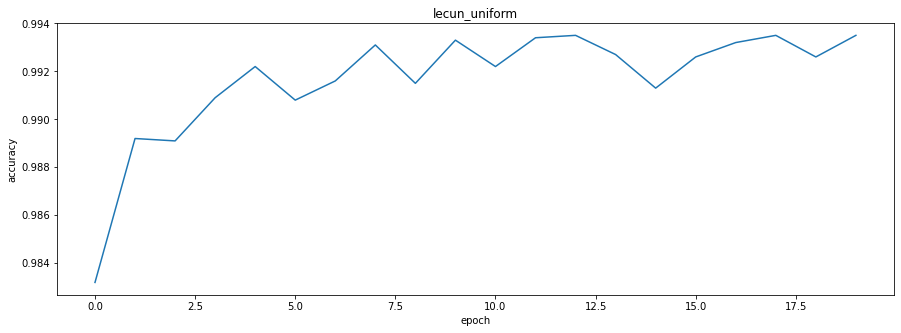

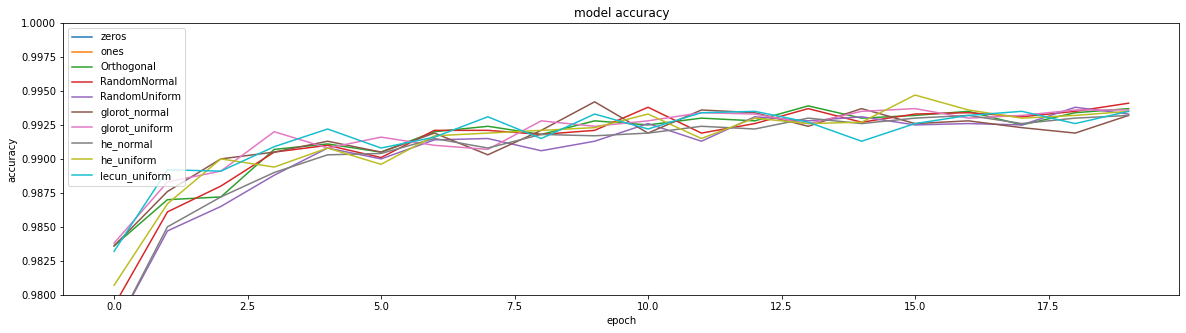

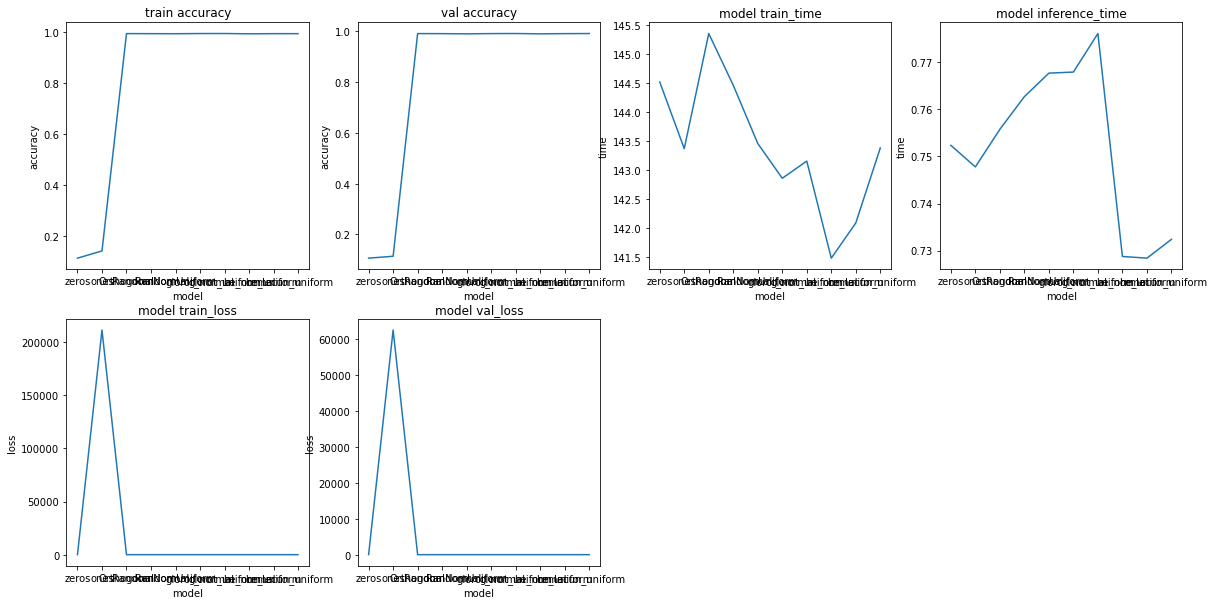

In [33]:
sample_int = weight_inifializations
names = weight_inifializations
for i in range(count):
    plt.figure(figsize=(15,5))
    plt.plot(history_weight_init[i].history['val_accuracy'])
    plt.title(weight_inifializations[i])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.savefig(weight_inifializations[i] + '-weight_inifializations.png', bbox_inches='tight')
    plt.show()
plot_generator("weight_inifializations",history_weight_init, names, len(weight_inifializations))

Considering the results we can directly say "zeros" and "ones" not suitable for our model at all. According to the results --- gives the best performance 

Decision - 

In [34]:
finalized_weight_initializer = 'glorot_normal'

## Experimenting with Different bias initializers

Bias initializers have a impact on the final accuracy and the convergence time. We analys each initializer and decided the best one.

In [35]:
bias_inifializations = ['zeros', 'ones',  'RandomNormal','RandomUniform','glorot_normal','glorot_uniform', 'he_normal','he_uniform','lecun_uniform']
neural_network = {}
count = len(bias_inifializations)
for j in range(count):
    neural_network[j] = Sequential()
    neural_network[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1),kernel_initializer= finalized_weight_initializer, bias_initializer= bias_inifializations[j]))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Conv2D(64,kernel_size=5,activation='relu',kernel_initializer= finalized_weight_initializer, bias_initializer= bias_inifializations[j]))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Flatten())
    neural_network[j].add(Dense(dense_layer_D, activation='relu',kernel_initializer= finalized_weight_initializer, bias_initializer= bias_inifializations[j]))
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Dense(10, activation='softmax',kernel_initializer= finalized_weight_initializer, bias_initializer= bias_inifializations[j]))
    neural_network[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [36]:
history = {}
names = bias_inifializations
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print("{0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        bias_inifializations[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_bias_init = history

313/313 [==============================] - 1s 2ms/step
zeros: Epochs=20, Train accuracy=0.99412, Validation accuracy=0.99430,trainning_time=143.48545, ,inference_time=0.73964
313/313 [==============================] - 1s 2ms/step
ones: Epochs=20, Train accuracy=0.98704, Validation accuracy=0.99290,trainning_time=143.03327, ,inference_time=0.72700
313/313 [==============================] - 1s 2ms/step
RandomNormal: Epochs=20, Train accuracy=0.99404, Validation accuracy=0.99420,trainning_time=142.48866, ,inference_time=0.73250
313/313 [==============================] - 1s 2ms/step
RandomUniform: Epochs=20, Train accuracy=0.99424, Validation accuracy=0.99330,trainning_time=142.78895, ,inference_time=0.75384
313/313 [==============================] - 1s 2ms/step
glorot_normal: Epochs=20, Train accuracy=0.99368, Validation accuracy=0.99450,trainning_time=142.65646, ,inference_time=0.73340
313/313 [==============================] - 1s 2ms/step
glorot_uniform: Epochs=20, Train accuracy=0.9934

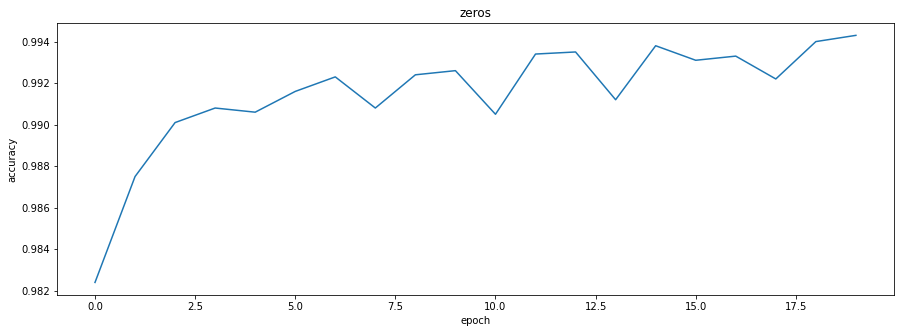

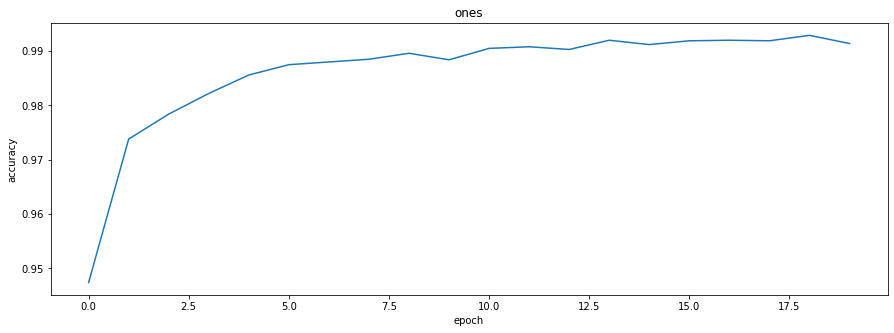

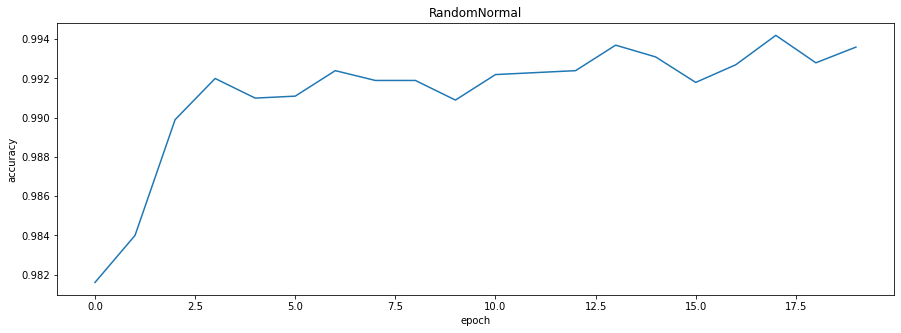

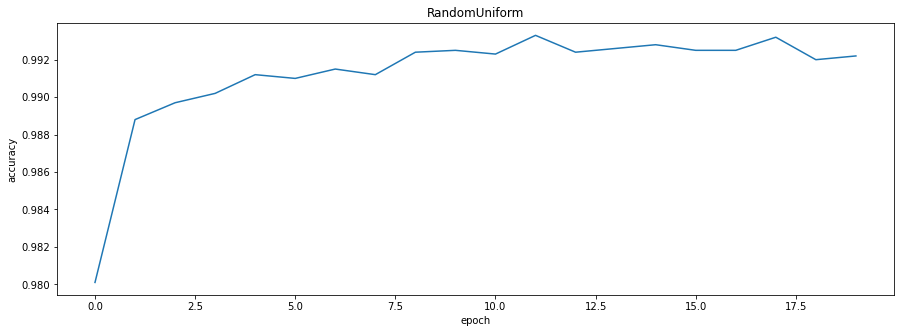

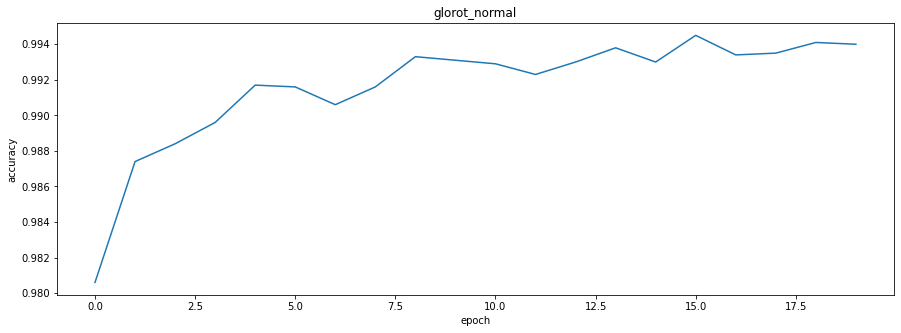

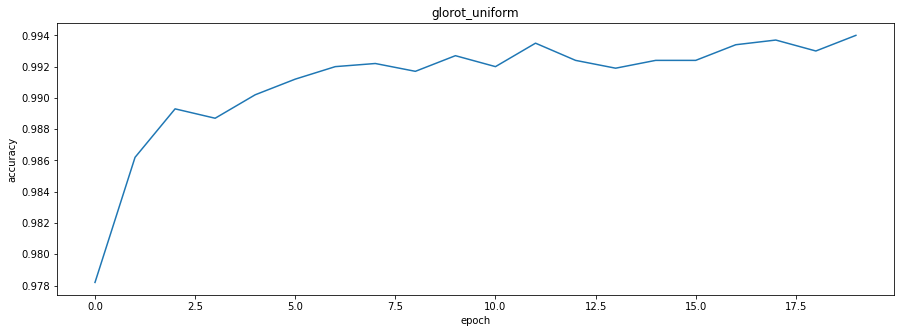

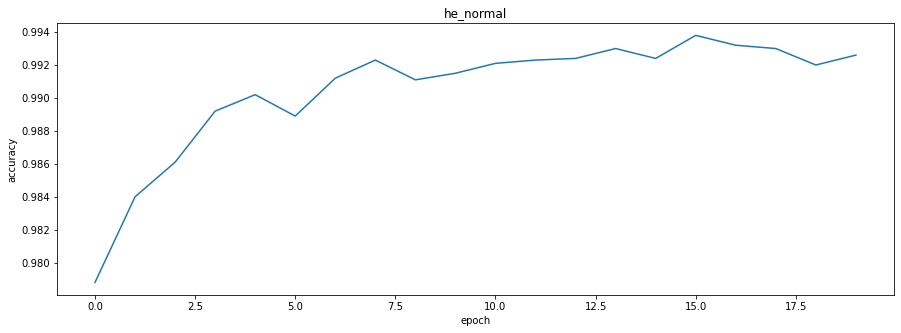

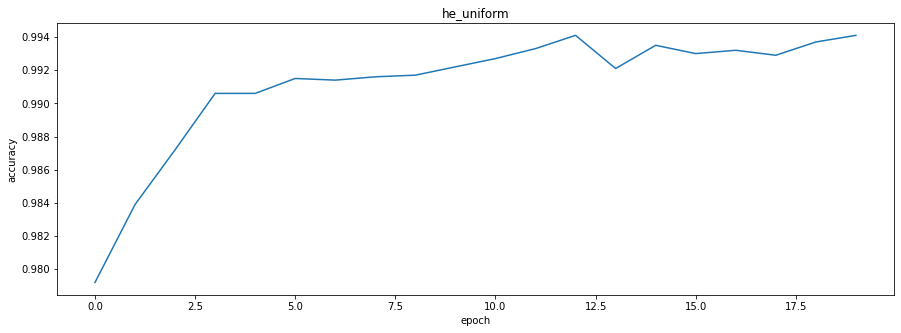

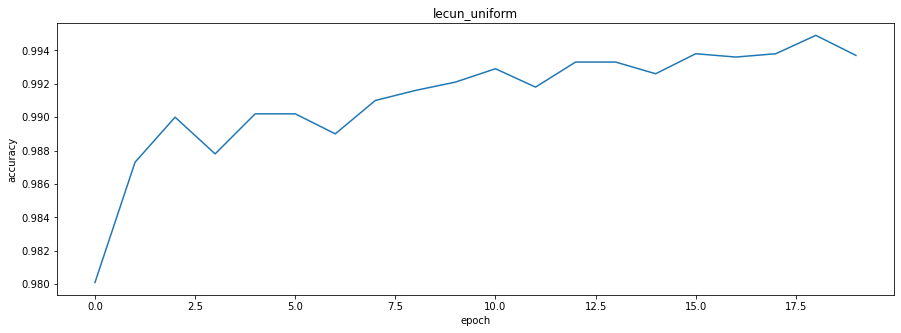

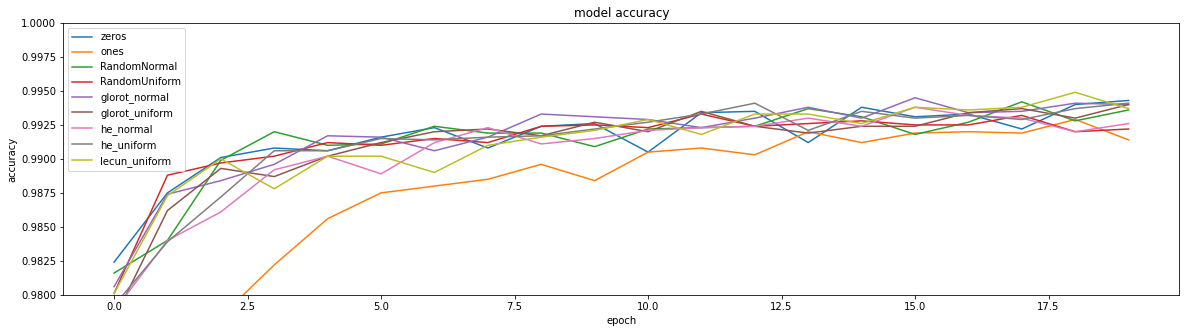

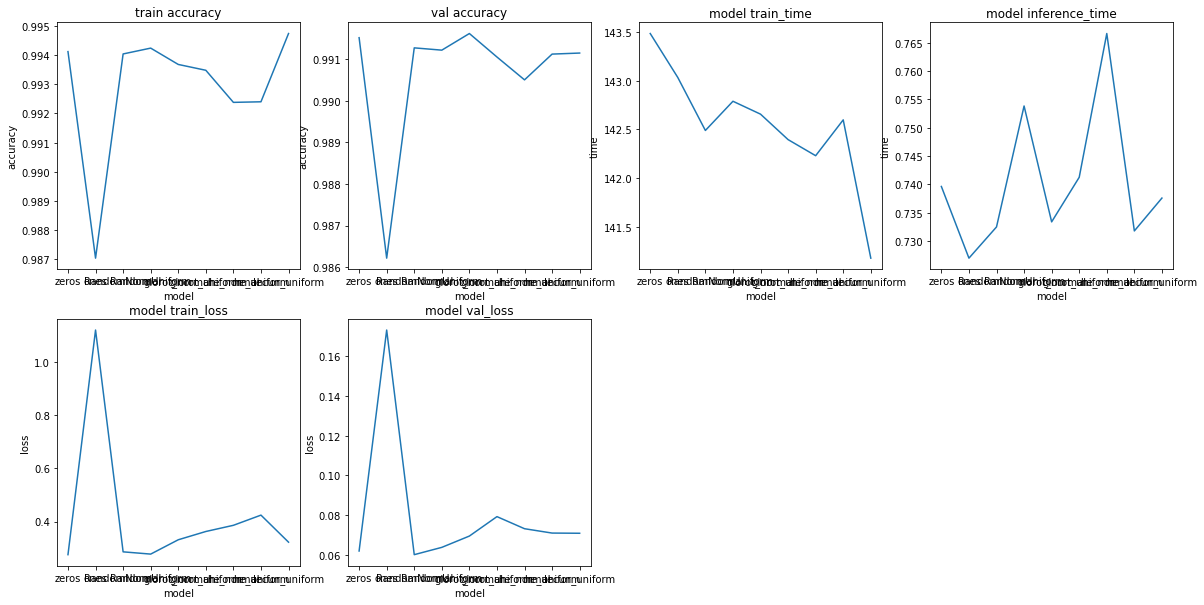

In [37]:
sample_int = bias_inifializations

for i in range(count):
    plt.figure(figsize=(15,5))
    plt.plot(history_bias_init[i].history['val_accuracy'])
    plt.title(bias_inifializations[i])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.savefig(bias_inifializations[i] + '-bias_inifializations.png', bbox_inches='tight')
    plt.show()
plot_generator("bias_inifializations",history_bias_init, names, len(bias_inifializations))

Considering the results we can directly say "zeros" and "ones" not suitable for our model at all. According to the results --- gives the best performance

Decision -

In [38]:
finalized_biass_initializer = 'zeros'

## Experimenting with Different Optimizers

Experiment is done to decide the best optimizer for the model. We cross checked the accuracies with difference optimizers.

In [39]:
optimizers = {'sgd':SGD(), 'rmsProp': RMSprop(),  'adam': Adam(), 'adadelta':Adadelta() ,'adagrad':Adagrad() ,'adamax': Adamax(), 'nadam':Nadam() ,'ftrl': Ftrl()}
neural_network = {}
names = list(optimizers.keys())
count = len(optimizers)
for j in range(count):
    neural_network[j] = Sequential()
    neural_network[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1), kernel_initializer= finalized_weight_initializer, bias_initializer = finalized_biass_initializer))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Conv2D(64,kernel_size=5,activation='relu', kernel_initializer= finalized_weight_initializer, bias_initializer = finalized_biass_initializer))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Flatten())
    neural_network[j].add(Dense(dense_layer_D, activation='relu',kernel_initializer= finalized_weight_initializer, bias_initializer = finalized_biass_initializer))
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Dense(10, activation='softmax', kernel_initializer= finalized_weight_initializer, bias_initializer = finalized_biass_initializer))
    neural_network[j].compile(optimizer=optimizers[names[j]], loss="categorical_crossentropy", metrics=["accuracy"])

In [40]:
history = {}
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print("Optimizer {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_optimizers= history

313/313 [==============================] - 1s 2ms/step
Optimizer sgd: Epochs=20, Train accuracy=0.97090, Validation accuracy=0.98460,trainning_time=139.55381, ,inference_time=0.74701
313/313 [==============================] - 1s 2ms/step
Optimizer rmsProp: Epochs=20, Train accuracy=0.99112, Validation accuracy=0.99330,trainning_time=140.94068, ,inference_time=0.73910
313/313 [==============================] - 1s 2ms/step
Optimizer adam: Epochs=20, Train accuracy=0.99420, Validation accuracy=0.99410,trainning_time=141.73862, ,inference_time=0.72849
313/313 [==============================] - 1s 2ms/step
Optimizer adadelta: Epochs=20, Train accuracy=0.57634, Validation accuracy=0.78930,trainning_time=142.62911, ,inference_time=0.73753
313/313 [==============================] - 1s 2ms/step
Optimizer adagrad: Epochs=20, Train accuracy=0.91852, Validation accuracy=0.95800,trainning_time=140.38912, ,inference_time=0.73648
313/313 [==============================] - 1s 2ms/step
Optimizer adamax

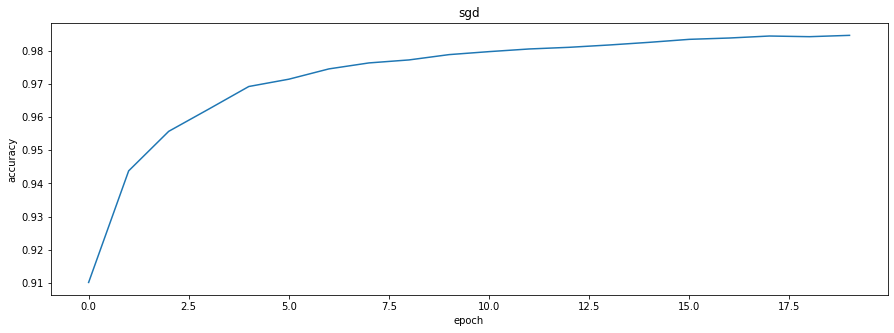

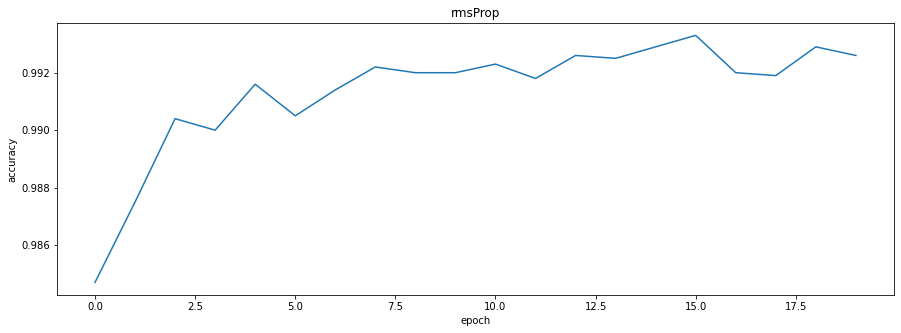

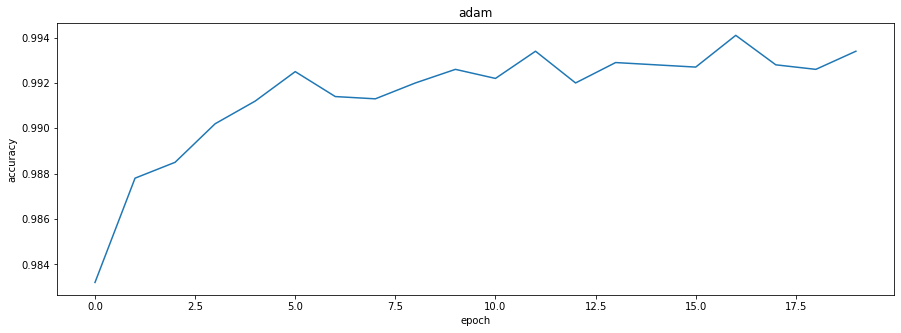

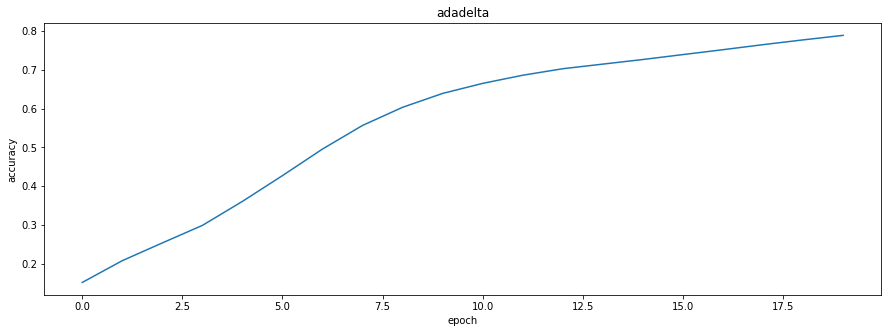

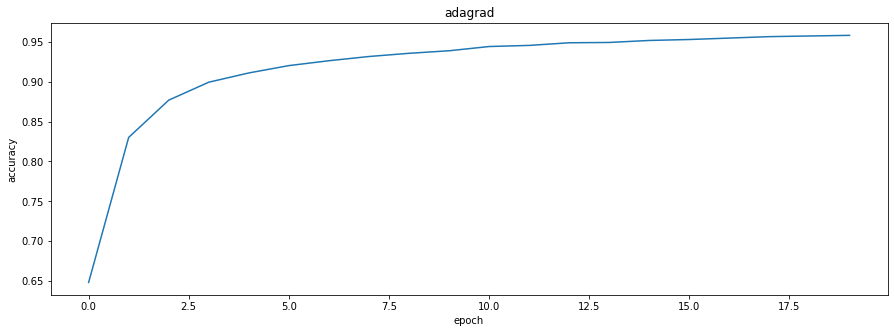

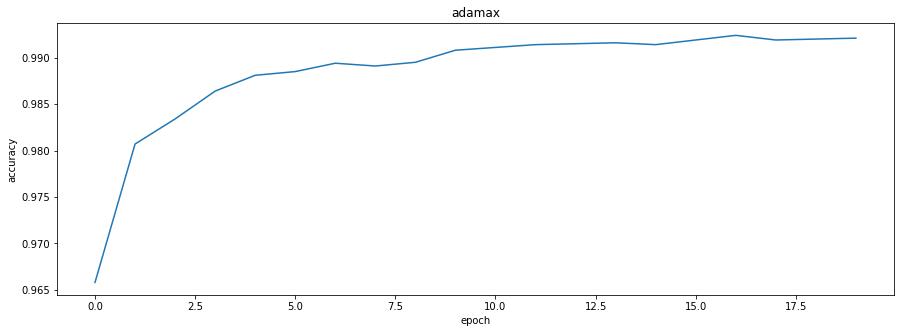

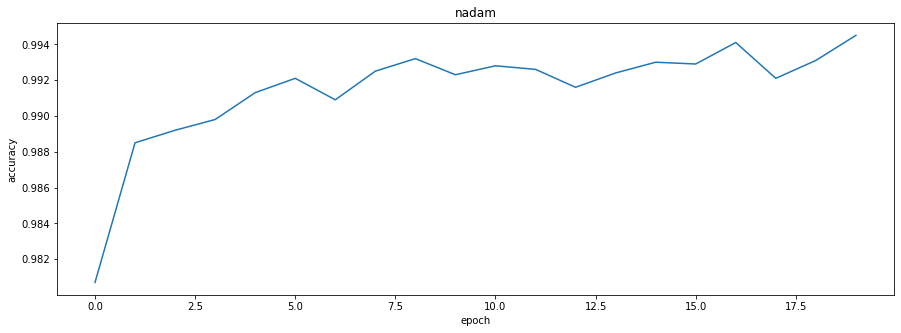

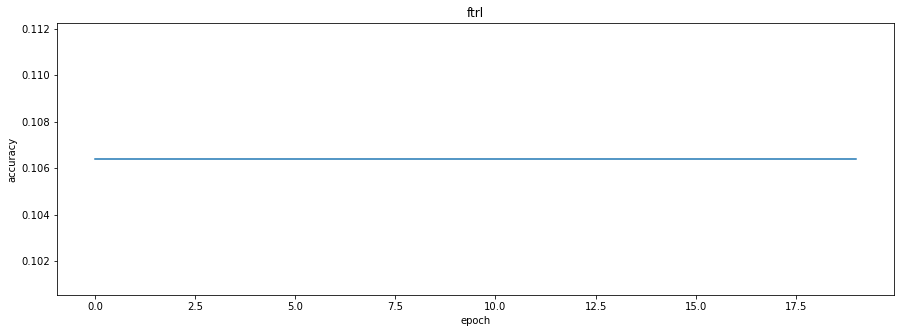

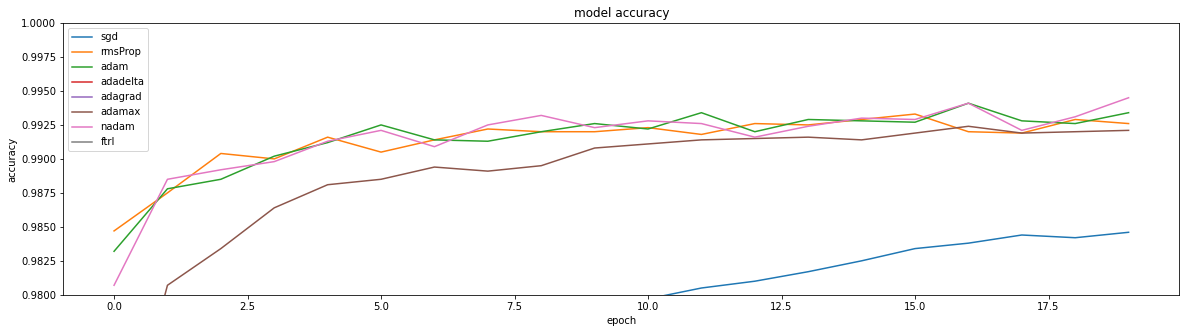

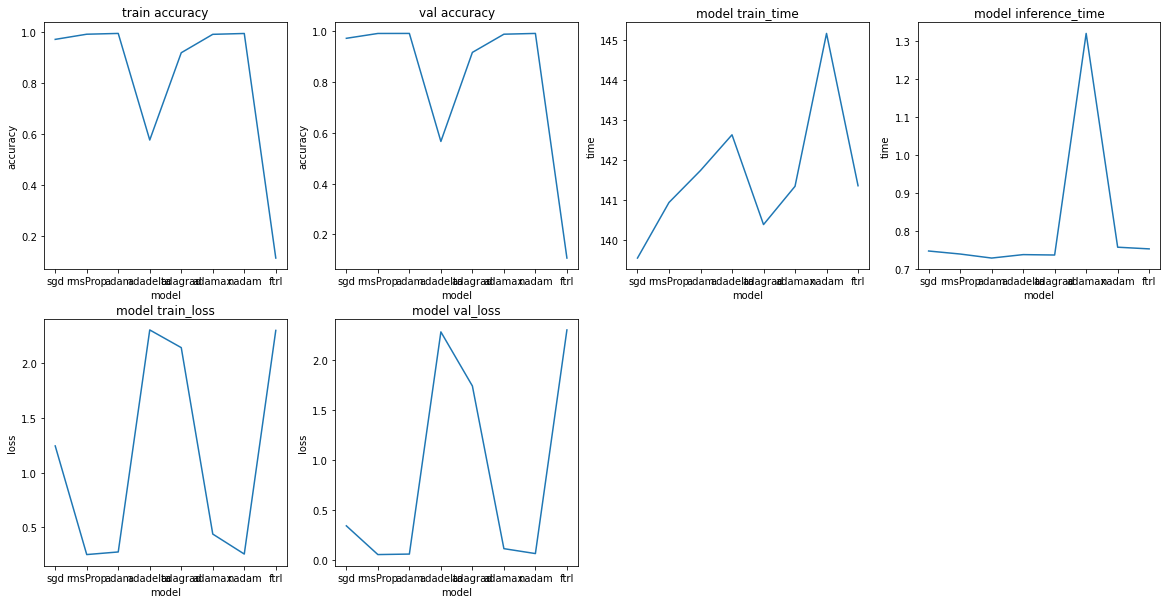

In [41]:
sample_int = optimizers
names = list(optimizers.keys())
for i in range(count):
    plt.figure(figsize=(15,5))
    plt.plot(history_optimizers[i].history['val_accuracy'])
    plt.title(names[i])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.savefig(names[i] + '-optimizers.png', bbox_inches='tight')
    plt.show()
plot_generator("optimizers",history_optimizers, names, len(names))

Considering the results we can see "Adam" and "Nadam" gives the best performance. Out of them "adam" has the best performance

Decision: Use "adam" optimizer

## Experimenting with Different Learning rates

Learning rate decide the convergence speed of the model. We experimented with difference Learning rates to find out the best performing learningrate.

In [42]:
learning_rates = [0.00001,0.0001,0.001,0.01,0.1]
count = len(learning_rates)
neural_network = {}
for j in range(count):
    neural_network[j] = Sequential()
    neural_network[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1), kernel_initializer= finalized_weight_initializer, bias_initializer = finalized_biass_initializer))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Conv2D(64,kernel_size=5,activation='relu', kernel_initializer= finalized_weight_initializer, bias_initializer = finalized_biass_initializer))
    neural_network[j].add(MaxPool2D())
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Flatten())
    neural_network[j].add(Dense(dense_layer_D, activation='relu', kernel_initializer= finalized_weight_initializer, bias_initializer = finalized_biass_initializer))
    neural_network[j].add(Dropout(0.3))
    neural_network[j].add(Dense(10, activation='softmax', kernel_initializer= finalized_weight_initializer, bias_initializer = finalized_biass_initializer))
    neural_network[j].compile(optimizer=Adam(learning_rate = learning_rates[j]), loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
history = {}
names = ["0.00001","0.0001","0.001","0.01","0.1"]
for j in range(count):
    start = time.time()
    history[j] = neural_network[j].fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
    end = time.time()
    trainning_time = end - start
    history[j].history["training_time"] = trainning_time
    start = time.time()
    neural_network[j].predict(x_val)
    end = time.time()
    inference_time = end - start
    history[j].history["inference_time"] = inference_time
    print("LR {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']),trainning_time, inference_time ))
history_learning_rate= history

313/313 [==============================] - 1s 2ms/step
LR 0.00001: Epochs=20, Train accuracy=0.93038, Validation accuracy=0.96290,trainning_time=150.66599, ,inference_time=0.77468
313/313 [==============================] - 1s 2ms/step
LR 0.0001: Epochs=20, Train accuracy=0.98462, Validation accuracy=0.99020,trainning_time=149.18843, ,inference_time=0.77841
313/313 [==============================] - 1s 2ms/step
LR 0.001: Epochs=20, Train accuracy=0.99430, Validation accuracy=0.99410,trainning_time=148.64851, ,inference_time=0.77166
313/313 [==============================] - 1s 2ms/step
LR 0.01: Epochs=20, Train accuracy=0.96228, Validation accuracy=0.98510,trainning_time=145.64730, ,inference_time=0.77364
313/313 [==============================] - 1s 2ms/step
LR 0.1: Epochs=20, Train accuracy=0.10690, Validation accuracy=0.10900,trainning_time=146.66703, ,inference_time=0.77958


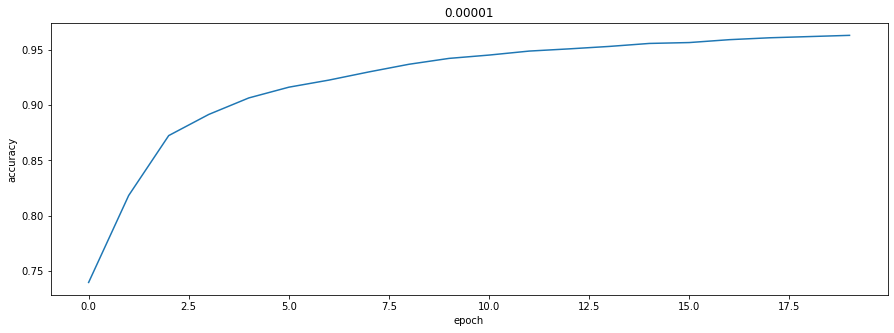

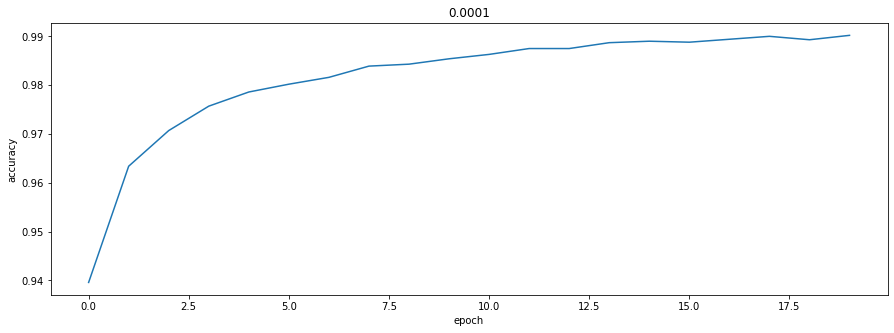

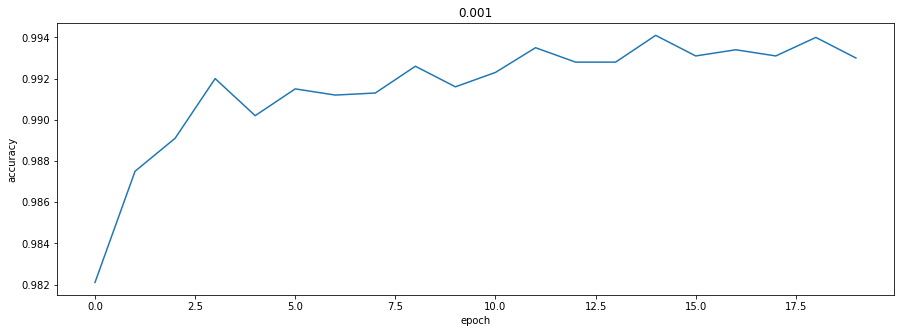

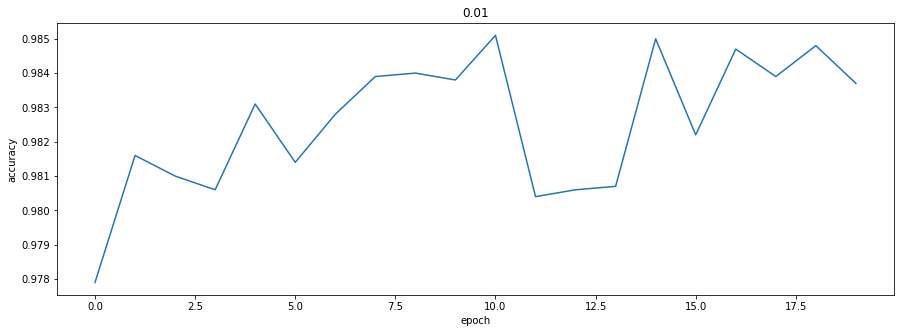

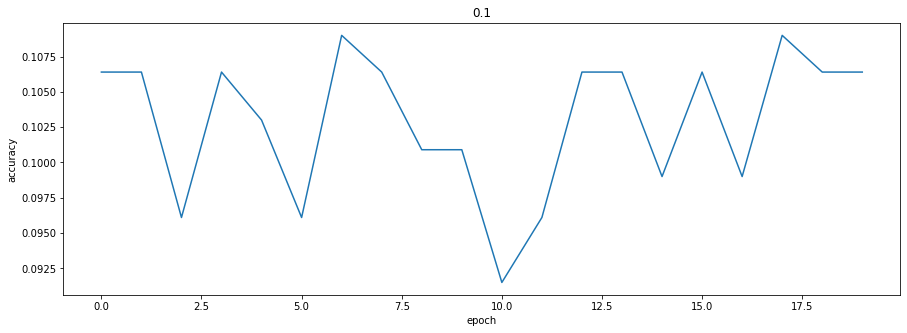

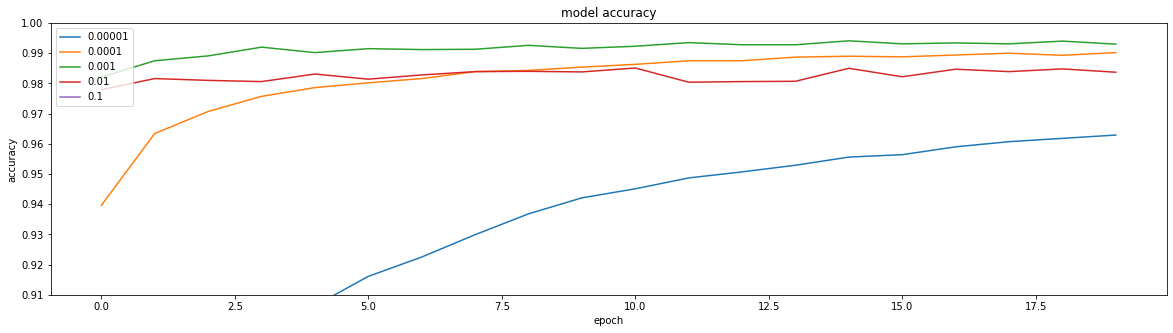

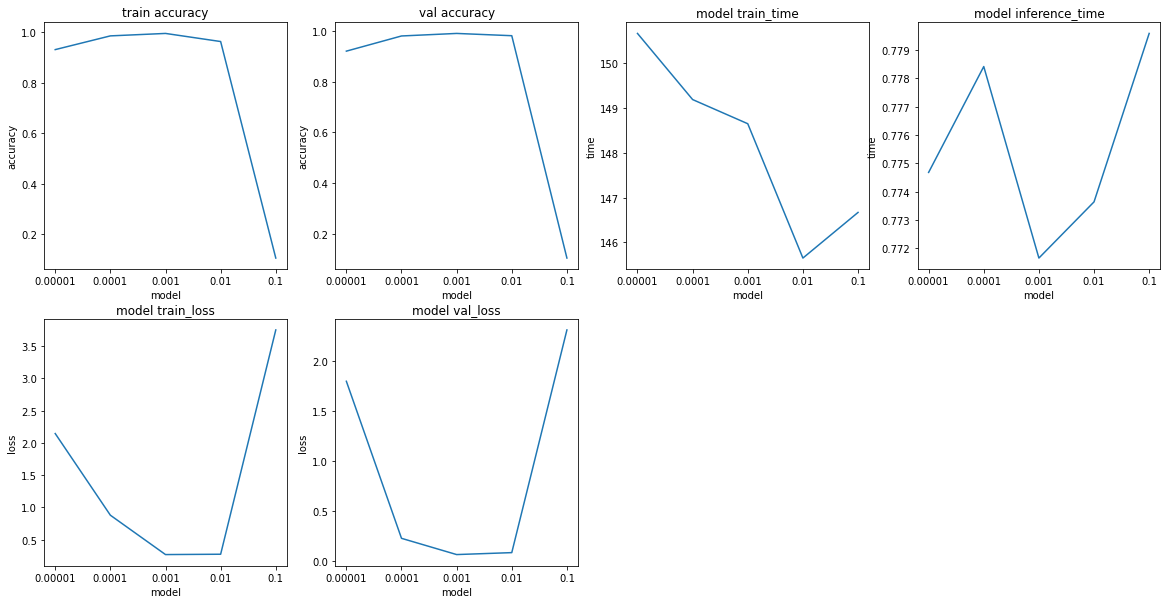

In [44]:
sample_int = learning_rates

for i in range(count):
    plt.figure(figsize=(15,5))
    plt.plot(history_learning_rate[i].history['val_accuracy'])
    plt.title(names[i])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    
    plt.show()
plot_generator("Learning rate",history_learning_rate ,names, len(learning_rates),0.91)

Through the results we can see that best learning rate is 0.001

Decision- Use learning rate 0.001

# Overall Decision


Considering all the above experiments best performance is given by following model<br>
Use Convolutional layer = True <br>
Number of convolutional layers = 2<br>
Is using dense layer before softmax =True<br>
Map size of convolutional layer = 32<br>
The size of the Dimension of dense layer = 256<br>
Drop out probability = 0.3<br>
The size of the Convolutional layer kernel = 5<br>
Weight Initializer = glorot_normal<br>
Bias Initializer = zeros<br>
Optimizer = Adam<br>
Learning rate = 0.001<br>
Note: The validation accuracy  as well as the order of the performance changed in different times. Therefore the above parameters have been selected after several runs and may not be giving best performance when executing above code.

In [65]:
#Following is the preliminary model which is a simple model of two fully connected hidden layer

neural_network = Sequential()
neural_network.add(Flatten())
neural_network.add(Dense(180, activation='relu', kernel_initializer= 'glorot_normal' , bias_initializer = 'zeros'))
neural_network.add(Dense(45, activation='relu', kernel_initializer= 'glorot_normal' , bias_initializer = 'zeros'))
neural_network.add(Dense(10, activation='softmax', kernel_initializer= 'glorot_normal' , bias_initializer = 'zeros'))
neural_network.compile(optimizer=Adam(learning_rate = 0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [55]:
epochs = 20
start = time.time()
history_final = neural_network.fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
end = time.time()
trainning_time = end - start
history_final.history["training_time"] = trainning_time
start = time.time()
neural_network.predict(x_val)
end = time.time()
inference_time = end - start
history_final.history["inference_time"] = inference_time
print(" {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
    "Final Values",epochs,max(history_final.history['accuracy']),max(history_final.history['val_accuracy']),trainning_time, inference_time ))

313/313 [==============================] - 0s 920us/step
 Final Values: Epochs=20, Train accuracy=0.99848, Validation accuracy=0.98060,trainning_time=21.32404, ,inference_time=0.45423


In [61]:
y_val_pred = neural_network.predict(x_val)
y_test_pred = neural_network.predict(x_test)
y_val_clz = [np.argmax(y, axis=None, out=None) for y in y_val]
y_val_pred_clz = [np.argmax(y, axis=None, out=None) for y in y_val_pred]
y_test_clz = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_pred_clz = [np.argmax(y, axis=None, out=None) for y in y_test_pred]
print("Validation Accuracy score    = ",accuracy_score(y_val_clz, y_val_pred_clz))
print("Accuracy score    = ", accuracy_score(y_test_clz, y_test_pred_clz))
print("Precision score   = ", precision_score(y_test_clz, y_test_pred_clz, average='macro'))
print("Recall score      = ", recall_score(y_test_clz, y_test_pred_clz, average='macro'))

313/313 [==============================] - 0s 891us/step
Validation Accuracy score    =  0.9769
Accuracy score    =  0.9776
Precision score   =  0.9773530636184029
Recall score      =  0.9775605842856457


In [66]:
#Following is the model which is a obtained from all the experimets
neural_network = Sequential()
neural_network.add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1), kernel_initializer= 'glorot_normal' , bias_initializer = 'zeros'))
neural_network.add(MaxPool2D())
neural_network.add(Dropout(0.3))
neural_network.add(Conv2D(64,kernel_size=5,activation='relu', kernel_initializer= 'glorot_normal' , bias_initializer = 'zeros'))
neural_network.add(MaxPool2D())
neural_network.add(Dropout(0.3))
neural_network.add(Flatten())
neural_network.add(Dense(256, activation='relu', kernel_initializer= 'glorot_normal' , bias_initializer = 'zeros'))
neural_network.add(Dropout(0.3))
neural_network.add(Dense(10, activation='softmax', kernel_initializer= 'glorot_normal' , bias_initializer = 'zeros'))
neural_network.compile(optimizer=Adam(learning_rate = 0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [63]:
epochs = 20
start = time.time()
history_final = neural_network.fit(x_train,y_train, batch_size=80, epochs = epochs, validation_data = (x_val,y_val), verbose = 0)
end = time.time()
trainning_time = end - start
history_final.history["training_time"] = trainning_time
start = time.time()
neural_network.predict(x_val)
end = time.time()
inference_time = end - start
history_final.history["inference_time"] = inference_time
print(" {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f},trainning_time={4:.5f}, ,inference_time={5:.5f}".format(
        "Final Values",epochs,max(history_final.history['accuracy']),max(history_final.history['val_accuracy']),trainning_time, inference_time ))


313/313 [==============================] - 1s 2ms/step
 Final Values: Epochs=20, Train accuracy=0.99514, Validation accuracy=0.99380,trainning_time=157.87859, ,inference_time=0.83057


In [64]:
y_val_pred = neural_network.predict(x_val)
y_test_pred = neural_network.predict(x_test)
y_val_clz = [np.argmax(y, axis=None, out=None) for y in y_val]
y_val_pred_clz = [np.argmax(y, axis=None, out=None) for y in y_val_pred]
y_test_clz = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_pred_clz = [np.argmax(y, axis=None, out=None) for y in y_test_pred]
print("Validation Accuracy score    = ",accuracy_score(y_val_clz, y_val_pred_clz))
print("Test Accuracy score    = ", accuracy_score(y_test_clz, y_test_pred_clz))
print("Precision score   = ", precision_score(y_test_clz, y_test_pred_clz, average='macro'))
print("Recall score      = ", recall_score(y_test_clz, y_test_pred_clz, average='macro'))

313/313 [==============================] - 1s 2ms/step
Validation Accuracy score    =  0.9936
Test Accuracy score    =  0.9932
Precision score   =  0.9931970548039208
Recall score      =  0.9931279346723849


The test accuracy we obtainted with the final model is 99.32%

The obtained model outperform the preliminary model way better.